In [ ]:
import matplotlib.pyplot as plt
from libpysal import graph
from neatnet import (
    consolidate_nodes,
    fix_topology,
    get_artifacts,
    remove_interstitial_nodes,
)

import core

In [2]:
case = "Liège"

Read road data

In [19]:
original = core.utils.read_original(case)
simplified = core.utils.read_results(case, "neatnet", original.crs)

Extract first part of the code from neatify.

In [5]:
eps = 1e-4
max_segment_length = 1

This takes bits from neatify.

In [10]:
roads = fix_topology(original, eps=eps)
# Merge nearby nodes (up to double of distance used in skeleton).
roads = consolidate_nodes(roads, tolerance=max_segment_length * 2.1)

# Identify artifacts
artifacts, threshold = get_artifacts(roads)
_, r_idx = roads.sindex.query(artifacts.geometry, predicate="contains")
# Dropping may lead to new false nodes – drop those
roads = remove_interstitial_nodes(roads.drop(roads.index[r_idx]))

# Filter singleton artifacts
rook = graph.Graph.build_contiguity(artifacts, rook=True)

# Keep only those artifacts which occur as isolates,
# e.g. artifacts that are not part of a larger intersection
singles = artifacts.loc[artifacts.index.intersection(rook.isolates)].copy()

# Filter doubles
artifacts["comp"] = rook.component_labels
counts = artifacts["comp"].value_counts()
doubles = artifacts.loc[artifacts["comp"].isin(counts[counts == 2].index)].copy()

# Filter clusters
clusters = artifacts.loc[artifacts["comp"].isin(counts[counts > 2].index)].copy()

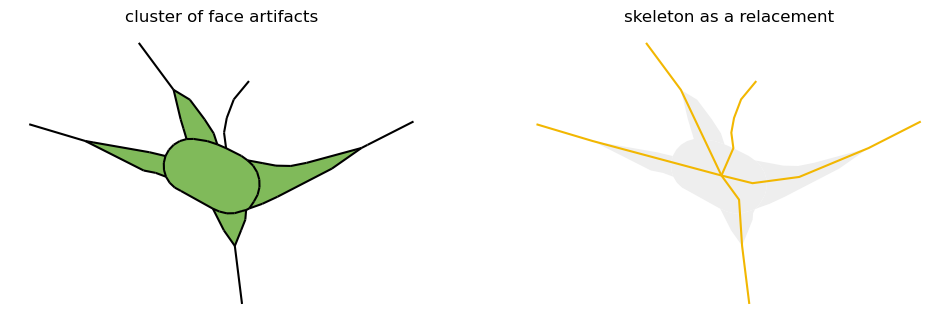

In [38]:
cluster = clusters[clusters.comp == 6]

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
cluster.plot(color="#80BA5A", ax=ax[0])
original.clip(cluster.union_all().buffer(20)).plot(ax=ax[0], color="k")
simplified.clip(cluster.union_all().buffer(20)).plot(ax=ax[1], color="#F2B701")
cluster.plot(color="#eeeeee", ax=ax[1])
for a in ax.flat:
    a.set_axis_off()
ax[0].set_title("cluster of face artifacts")
ax[1].set_title("skeleton as a relacement")
plt.savefig("../../illustrations/skeletonize.png", dpi=300, bbox_inches="tight")